Group Name: AG xx.

Student Name (Student ID):

1. xxxx xxxxx (xxxxxxx)

2. xxxx xxxxx (xxxxxxx)

3. xxxx xxxxx (xxxxxxx)

In [1]:
from __future__ import annotations
import csv
import math
import random
import matplotlib.pyplot as plt
from itertools import combinations
from typing import Tuple, List, Dict, Union
from heapq import heappush, heappop
from functools import reduce

# Question 2

## Introduction to question 2

In the second question of this assignment, we will explore the use of local search in genome assembly.

We will use local search to assemble (construct) a large part of the nucleotide sequence of the monkeypox virus, which has been downloaded from the National Center for Biotechnology Information in the United States. Please note that no additional or specialized knowledge of biology or bioinformatics is required for this assignment. (Actually, the technical specifics of bioinformatics have been adapted and simplified for the purposes of this computer science assignment, so if you are a biologist, please do not apply preexisting knowledge to solve the problem. Furthermore, you should not attempt to search up the genome on genomic databases to "guess" the actual sequence, since we are more interested in your coding methodology rather than your attempts at reproducing a known sequence.)

This is an introductory computer science assignment and not a bioinformatics assignment; we are simply using bioinformatics as a use case to illustrate the applicability of local search to the natural sciences. Therefore, no knowledge of bioinformatics is assumed or required. In the paragraphs that follow, I will give a short crash course which will cover all the domain knowledge you will need to know in order to tackle this problem.  

For technical reasons, when we analyze the nucleotide sequence (genome) of a virus, we usually cannot “read” it in one fell swoop. We have to read the genome in parts, because the genome is usually too long for the machine to read in a single sitting. To simplify things, a “read” is a single view of part of the genome; think of it as a SUBSTRING, a partial view of the whole genome. After we have generated multiple reads of a genome, we then have to “stitch”, or combine, the different reads of the genome together. This process of stitching up reads of a genome into the final sequence is known as genome assembly. However, the different reads of the genome cannot just be concatenated like usual string concatenation. It’s not a situation where you have one read, “Hello”, and another read, “World”, and all you need to do is concatenate both strings together to make “Hello World”. Among other reasons, there are two major reasons why you can’t do so:

1. You do not know which read came first. The reads are not ordered. How do you know “Hello” came after “World”? The answer is that you don’t. Imagine how complicated this situation might be if you had more than two reads. (This is indeed our situation, where we have $n$ reads, and $n>>2$.)

2. One read may contain a substring contained in another read. Specifically, without loss of generality, part of the ending $x$ characters of a read (i.e., suffix) might also be found in the starting $x$ positions (i.e., prefix) of another read.

- A computer scientist usually creates opportunities from problems. While this may be a “problem” in that you just can’t concatenate two strings blindly, the fact that strings contain shared “substrings” is actually a very helpful clue that you can use to “join” strings together. 

- Note that the choice of the value of $x$ could be a hyperparameter decided by the computer scientist.

## Your tasks

In this part of the assignment, you will work with (simulated) reads that I have generated from the nucleotide sequence of the monkeypox virus. In reality, bioinformatics is far more complicated, but here we will work with a simplified situation. Your task is to examine the reads that I have provided for you, and from there “infer” the nucleotide sequence that might have produced those reads. 

The reads are provided in the csv file `data.csv` which simply provides a list of unique strings. Note that you should NOT assume any particular ordering of the strings in this dataframe. In fact, the strings have already been shuffled randomly. 

NOTE: You are not allowed to use `pandas` or any other libraries apart from the Python STL to load the csv file.

### Task A (3 marks): 

Create a directed graph. The nodes in the graph are the strings in the list of reads. An edge should be drawn FROM read A TO read B if and only if a suffix (of length $x$) of read A is also a prefix (obviously, also of length $x$) of read B. For the purposes of the assignment, limit the value of $x$ to between 5 and 30, both inclusive. That is, to be clear, $5\leq x\leq 30$. The weight of an edge between read A and read B should be the NEGATED value of $x$, i.e. $-x$. 

In your Jupyter notebook, please report the number of edges in your graph. Provide a barplot or histogram which shows the number of edges with different weights or weight categories. In this task, you are free to use plotting libraries such as `matplotlib` or `seaborn` to plot this graph.

As an example, if read A is "TACTAGT" and read B is "TAGTCCCCT", then an edge is drawn FROM read A TO read B (i.e., $A \rightarrow B$) with weight of $-4$. This is because the 4-suffix "TAGT" is also the 4-prefix of read B; in other words, the last 4 characters of read A (a substring of length 4) overlap with the first 4 characters of read B (a substring of length 4).

### Task B (7 marks): 

From Task A, you now have a graph which shows connections between reads based on how they overlap, in theory you could draw a path through the graph and thereby derive the full sequence (genome).

Task B asks you to use local search method(s) to determine a path through this directed graph of strings. 

- You are expected to use simulated annealing and tune the relevant configuration settings and hyperparameters. The minimum requirement is to implement simulated annealing.

- Explain tha rationale behind the choice of scheduling strategy and parameters.

- However, you may also explore other search methods in addition to simulated annealing. Marks will be awarded for effort.

Note the following constraints:

1. The path has to go through each and every vertex exactly once. For computer scientists, this constraint is reminiscent of the "Traveling Salesman's Problem", except that unlike TSP, we should not need to go back to the starting vertex again. 

2. For the purposes of neighbor generation / action selection at each node, bear in mind that a path through the graph which minimizes the total number of nucleotides in the assembled sequence is the preferred path. To state that another way, the assembled sequence should be derived from a path that goes through EACH and EVERY vertex exactly once, however we want this assembled sequence to be AS SHORT AS POSSIBLE.

3. You are not given the starting (source/origin) or ending (destination) vertex.

4. For avoidance of ambiguity, no cycles are allowed. You must not visit a vertex more than once.

5. You are not allowed to use any libraries apart from the Python Standard Library.
No import statements which import libraries outside of the Python STL should be found within your answer for Task B.

Please remember to report the assembled sequence that you obtain. Although it would be great if you can come up with a good sequence, please feel reassured that we are more interested in your APPROACH to the problem, and so you can potentially get a reasonable score on this task even if your solution is "wrong". It is the process, rather than the result, which matters more.

In [2]:
# Problem Class
class Problem:
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default heuristic is 0 and the default action cost is 1 for all states.
    When you create an instance of a subclass, specify `initial`, and `goal` states 
    (or give an `is_goal` method) and perhaps other keyword args for the subclass."""

    def __init__(self, initial=None, goal=None, **kwds): 
        self.__dict__.update(initial=initial, goal=goal, **kwds) 
        
    def actions(self, state):        raise NotImplementedError
    def result(self, state, action): raise NotImplementedError
    def is_goal(self, state):        return state == self.goal
    def action_cost(self, s, a, s1): return 1
    def h(self, node):               return 0
    
    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)

In [3]:
# Use the following Node class to generate search tree
import math
class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0, **kwds):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost, **kwds)

    def __repr__(self): return '<{}>'.format(self.state)
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): return self.path_cost < other.path_cost 
    def __eq__(self, other): return isinstance(other, Node) and self.state == other.state
    def expand_node(self, state, cost):
        new_node = Node(state, 
                   path_cost=self.path_cost + cost,
                   cost = cost,
                   parent=self)
        return new_node
    
    # Below are methods adapted from the aima4e python directory
    # https://github.com/aimacode/aima-python/blob/master/search.py
    def expand(self, problem):
        """List the nodes reachable in one step from this node."""
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]
    
    def child_node(self, problem, action):
        """[Figure 3.10]"""
        next_state = problem.result(self.state, action)
        next_node = Node(next_state, self, action, problem.path_cost(self.path_cost, self.state, action, next_state))
        return next_node

In [4]:
class ProblemException(Exception):
    pass

# Code to generate neighbours, value of states, etc.
class TSP(Problem):
    #Implement TSP class here
    def load_data(self) -> dict:
        """Loads data from path provided

        Args:
            path (str): local path to file

        Returns:
            dict: 
                dict in the following schema:
                {READ_INDEX (str): READ_SEQUENCE (str)}
        """
        data = {}
        with open(self.data_path) as file:
            entries = map(dict, csv.DictReader(file))
            for entry in entries:
                data[entry['read_index']] = entry['read_sequence']
        self.data = data
    
    def calculate_weight(self, a_string: str, b_string: str) -> int:
        """
        Args:
            a_string (str): String to compare as from node
            b_string (str): String to compare as to node

        Returns:
            int:
                Weight with -ve of a -> b
        """
        if a_string == b_string:
            return -30
        for i in range(1, 26):
            if a_string[i:] == b_string[:-i]:
                return -(30-i)
        return 0
    
    def calculate_weights(self) -> None:
        """
        Args:
            csv_data (dict):
                Data from csv with the following schema {READ_NAME (str): READ_SEQUENCE (str)}

        Attributes:
            weights:
                Dict with the following schema:  
                {('READ_#', 'READ_#2'): WEIGHT_OF_READ#_TO_READ#2}
            adjacency_matrix:
                Save read to read costs
            stat:
                Save reads in flat form to report statistics
        """
        weights = {}
        set_added = set()
        stat = []
        
        adjacency_matrix = [[0 for j in range(len(self.data))] for i in range(len(self.data))]
        for sequences in combinations(self.data.items(), 2):
            ((read_name_1, sequence_1), (read_name_2, sequence_2)) = sequences
            if read_name_1 == read_name_2:
                continue

            weight_1_2 = self.calculate_weight(sequence_1[-30:],sequence_2[:30])
            if weight_1_2:
                weight_lib = weights.get(read_name_1, [])
                heappush(weight_lib, (weight_1_2, read_name_2))
                weights[read_name_1] = weight_lib
                adjacency_matrix[self._get_node_index(read_name_1)]\
                                [self._get_node_index(read_name_2)] = weight_1_2
                stat.append(weight_1_2)

            weight_2_1 = self.calculate_weight(sequence_2[-30:],sequence_1[:30])
            if weight_2_1:
                weight_lib = weights.get(read_name_2, [])
                heappush(weight_lib, (weight_2_1, read_name_1))
                weights[read_name_2] = weight_lib
                adjacency_matrix[self._get_node_index(read_name_2)]\
                                [self._get_node_index(read_name_1)] = weight_2_1
                stat.append(weight_2_1)
        self.weights = weights
        self.adjacency_matrix = adjacency_matrix
        self.stat = stat


    def is_cycle(self, node: Node):
        read = node.state
        while node.parent is not None:
            if node.parent.state == read:
                return True
            node = node.parent
        return False
    
    def _get_node_index(self, read: str) -> int:
        """
        Helper methods to get read index given read name
        """
        return int(read.split('_')[1])

    def _convert_node_index(self, read_index: int) -> str:
        """
        Helper methods to get read name given node index
        """
        return f'read_{read_index}'
    
    def find_lowest_path(self, initial_node: Node) -> Node:
        """Greedy algorithm to find the lowest path
        
        Args:
            initial_node (Node): Initial starting node
        
        Returns:
            solution_node (Node): if found
        """
        # instantiate weights lookup
        self.calculate_weights()
        
        visited = [0 for i in range(len(self.weights))]
        visited[self._get_node_index(initial_node.state)] = 1
        current_node = (0, initial_node)

        total_number_of_nodes = len(self.weights)
        travelled_nodes = 1
        while travelled_nodes < total_number_of_nodes:
            path_cost, read = current_node
            neighbours = self.weights[read.state]
            found_neighbours = False
            while neighbours:
                cost, neighbour = heappop(neighbours)
                neighbour_index = self._get_node_index(neighbour)
                if not visited[neighbour_index]:
                    current_node = (cost, read.expand_node(neighbour, cost))
                    travelled_nodes += 1
                    visited[neighbour_index] = 1
                    found_neighbours = True
                    break
            if not found_neighbours:
                not_visited_index = visited.index(0)
                current_node = (0, 
                                read.expand_node(
                                        self._convert_node_index(not_visited_index), 0)
                                )
                travelled_nodes += 1
                visited[not_visited_index] = 1
        return current_node
    
    def get_read_order(self, node: Node) -> List[str]:
        """Given a node, traces back the order
        for which the graph was traversed.
        
        Args:
            node (Node): Solution node
        
        Returns:
            List[str]:
                List of reads for which was traversed
                in order
        """
        order = []
        while node.parent is not None:
            order.append((node.state, node.cost))
            node = node.parent
        order.append((node.state, 0))
        return order[::-1]
    
    def recreate_str(order: List[Tuple[str, int]]) -> str:
        """Recreates the string based on the order list
        Args:
            order (List[Tuple[str, int]]):
                order and cost from n-1 to n of the read
        
        Returns:
            str:
                Final reconstructed string
        """
        final_string: str = self.data[order[0][0]]
        for i in range(0, len(weights)-1):
            final_string += self.data[order[i+1][0]][-order[i+1][1]:]
        return final_string
    
    def value(self, order: Union[List[Tuple[str, int]], Node]) -> int:
        """Calculates the total characters shortened
        given a read order in the form of 
        List[tuple[read_name (str), cost_to_this_read (int)]]
        
        Args:
            order (List[Tuple[str, int]]):
                order and cost from n-1 to n of the read
        
        Returns:
            int:
                Cost of traversal
        """
        if isinstance(order, Node):
            order = order.state
        if len(order) < len(self.data):
            raise ProblemException(
                'Order is incomplete; there are less entries of traversal'
            )
        return reduce(lambda x, y: x + y, map(lambda x: x[1], order))
    
    def regenerate_order_weights(self, order: List[str]) -> List[Tuple[str, int]]:
        """Calculate edge weights for a given read order

        Args:
            order:
                Order of weights for a given list of reads

        Returns:
            List[Tuple[str, int]]:
                Order with costs in tuple index 1
        """
        entries = [(order[0], 0)]
        for i in range(1, len(order)):
            cost = tsp.adjacency_matrix[tsp._get_node_index(order[i-1])]\
                    [tsp._get_node_index(order[i])]
            entries.append((order[i], cost))
        return entries
    
    def path_cost(self,
                  cost: int,
                  state1: List[Tuple[str, int]],
                  action: str,
                  state2: List[Tuple[str, int]]) -> int:
        """Recalculate weights given order of state2, then
        finds the total cost for the weights and return the result
        """
        return self.value(state2)
    
    # Below are methods adapted from the aima4e python directory
    # https://github.com/aimacode/aima-python/blob/master/gui/tsp.py
    def two_opt(self, state):
        """Neighbour generating function for Traveling Salesman Problem"""
        # remove the ordered costs due to changes that will be made
        if not isinstance(state, Node):
            neighbour_state = list(map(lambda x: x[0], state))
        else:
            neighbour_state = list(map(lambda x: x[0], state.state))
        
        left = random.randint(0, len(neighbour_state) - 1)
        right = random.randint(0, len(neighbour_state) - 1)
        if left > right:
            left, right = right, left
        neighbour_state[left: right + 1] = reversed(neighbour_state[left: right + 1])
        return neighbour_state

    def actions(self, state):
        """action that can be executed in given state"""
        return [self.two_opt]
    
    def result(self, state, action):
        return self.regenerate_order_weights(action(state))
    
    def probability(self, p):
        """Return true with probability p."""
        return p > random.uniform(0.0, 1.0)
    
    def exp_schedule(self, 
                     temperature: int=40,
                     k: int=20,
                     lam: float=0.005,
                     limit: int=100) -> Union[int, float]:
        """Adapted from exp_schedule aima4e repo, but exposing parameters
        for hyperparameter tuning
        Args:
            k (int): 
            temperature (int): temperature
            lam (float): lambda to set change / 'bounce' rate variation / degree
            limit (int): limit to set to exit 
        """
        return -k * math.exp(-lam * temperature) if temperature < limit else 0
    
    def simulated_annealing(self, **kwargs):
        """Simulated annealing where temperature is taken as user input"""
        current = self.initial
        self.reads = []
        while True:
            # Pass keyword args direct to schedule for 
            # hyperparameter tuning
            T = self.exp_schedule(**kwargs)
            if T == 0:
                return current.state
            neighbour = current.expand(self)
            if not neighbour:
                return current.state
            delta_e = self.value(neighbour[0]) - self.value(current)
            if delta_e < 0 or self.probability(math.exp(delta_e / T)):
                current = neighbour[0]
                self.cost = "Cost = " + str('%0.3f' % (self.value(current)))
                self.reads.append(self.value(current))
                print(self.cost)
                self.final = current

In [5]:
read = Node('read_596') # initial node

In [6]:
tsp = TSP(initial=None, initial_node=read, data_path='data.csv') 

In [7]:
tsp.load_data()

In [8]:
tsp.calculate_weights()

## Statistics

Number of edges in the graph: 1507
Histogram of distribution of weights:



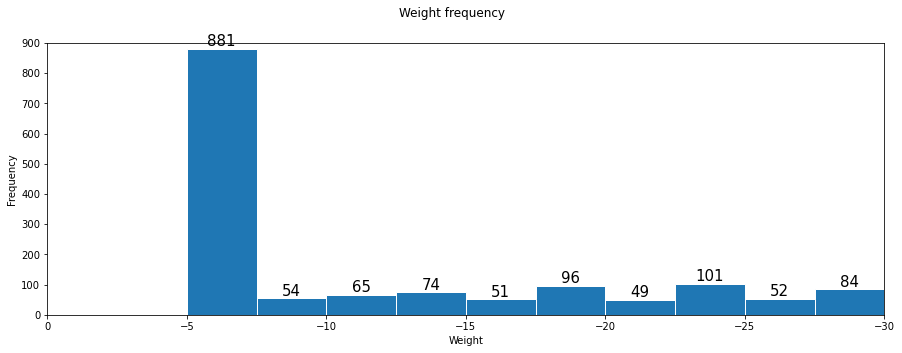

In [9]:
# Reporting number of edges
print(f'Number of edges in the graph: {len(tsp.stat)}')

# Plotting the figure for distribution of edge weights
# using bins (histogram)
print('Histogram of distribution of weights:\n')
plt.figure(figsize=(15,5))
values, bins, bars = plt.hist(tsp.stat, density=False, edgecolor='white')
plt.axis([0, -30, 0, 900]) 
plt.suptitle('Weight frequency')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.bar_label(bars, fontsize=15, color='black')
plt.margins(x=0.01, y=0.1)

In [10]:
cost, final_node = tsp.find_lowest_path(tsp.initial_node)

In [11]:
read_order = tsp.get_read_order(final_node)

In [12]:
tsp.value(read_order)

-12011

Note: Uncomment and use only one of the below for simulation

In [13]:
# test 1, from a seeded node
# tsp.initial = Node(state=read_order, path_cost=tsp.value(read_order))

In [14]:
# test 2, from a random node
sample = list(map(lambda x: x[0], random.sample(read_order, 599)))
sample = tsp.regenerate_order_weights(sample)
sample
tsp.initial = Node(state=sample, path_cost=tsp.value(sample))

In [15]:
tsp.initial.path_cost

0

In [16]:
neighbour = tsp.initial.expand(tsp)[0]

In [17]:
# Using a lambda 0.05 vs 0.005 or 0.0005 yields more expected results.
# This is as lambda determines the vary rate to 'shake' the 
# output out of the trench.
tsp.simulated_annealing(k= 20,
                        temperature=30,
                        lam=0.05,
                        limit = 9999999999999) 

Cost = 0.000
Cost = 0.000
Cost = 0.000
Cost = 0.000
Cost = 0.000
Cost = 0.000
Cost = 0.000
Cost = 0.000
Cost = 0.000
Cost = 0.000
Cost = 0.000
Cost = 0.000
Cost = -5.000
Cost = -5.000
Cost = -5.000
Cost = -5.000
Cost = -5.000
Cost = -5.000
Cost = -5.000
Cost = -5.000
Cost = -5.000
Cost = 0.000
Cost = 0.000
Cost = 0.000
Cost = 0.000
Cost = -5.000
Cost = -5.000
Cost = -5.000
Cost = -5.000
Cost = -5.000
Cost = -5.000
Cost = -5.000
Cost = -5.000
Cost = -5.000
Cost = -5.000
Cost = -5.000
Cost = -5.000
Cost = -5.000
Cost = -5.000
Cost = -5.000
Cost = -10.000
Cost = -15.000
Cost = -15.000
Cost = -15.000
Cost = -15.000
Cost = -15.000
Cost = -15.000
Cost = -15.000
Cost = -15.000
Cost = -10.000
Cost = -5.000
Cost = -10.000
Cost = -10.000
Cost = -10.000
Cost = -5.000
Cost = -10.000
Cost = -10.000
Cost = -5.000
Cost = -10.000
Cost = -5.000
Cost = -5.000
Cost = -5.000
Cost = -10.000
Cost = -15.000
Cost = -15.000
Cost = -15.000
Cost = -15.000
Cost = -5.000
Cost = -15.000
Cost = -15.000
Cost = -15.00

Cost = -99.000
Cost = -100.000
Cost = -100.000
Cost = -95.000
Cost = -94.000
Cost = -99.000
Cost = -99.000
Cost = -109.000
Cost = -109.000
Cost = -109.000
Cost = -114.000
Cost = -114.000
Cost = -114.000
Cost = -103.000
Cost = -103.000
Cost = -98.000
Cost = -98.000
Cost = -104.000
Cost = -104.000
Cost = -104.000
Cost = -104.000
Cost = -104.000
Cost = -99.000
Cost = -94.000
Cost = -99.000
Cost = -94.000
Cost = -94.000
Cost = -94.000
Cost = -89.000
Cost = -89.000
Cost = -94.000
Cost = -94.000
Cost = -94.000
Cost = -94.000
Cost = -89.000
Cost = -94.000
Cost = -94.000
Cost = -94.000
Cost = -85.000
Cost = -99.000
Cost = -99.000
Cost = -99.000
Cost = -99.000
Cost = -99.000
Cost = -99.000
Cost = -99.000
Cost = -99.000
Cost = -99.000
Cost = -94.000
Cost = -94.000
Cost = -94.000
Cost = -99.000
Cost = -88.000
Cost = -94.000
Cost = -94.000
Cost = -94.000
Cost = -94.000
Cost = -94.000
Cost = -94.000
Cost = -94.000
Cost = -85.000
Cost = -94.000
Cost = -94.000
Cost = -94.000
Cost = -94.000
Cost = -94

Cost = -248.000
Cost = -248.000
Cost = -248.000
Cost = -253.000
Cost = -253.000
Cost = -259.000
Cost = -259.000
Cost = -265.000
Cost = -265.000
Cost = -265.000
Cost = -265.000
Cost = -265.000
Cost = -265.000
Cost = -265.000
Cost = -265.000
Cost = -265.000
Cost = -265.000
Cost = -260.000
Cost = -260.000
Cost = -265.000
Cost = -265.000
Cost = -265.000
Cost = -265.000
Cost = -265.000
Cost = -265.000
Cost = -260.000
Cost = -255.000
Cost = -260.000
Cost = -266.000
Cost = -266.000
Cost = -266.000
Cost = -266.000
Cost = -266.000
Cost = -252.000
Cost = -252.000
Cost = -266.000
Cost = -266.000
Cost = -266.000
Cost = -266.000
Cost = -266.000
Cost = -271.000
Cost = -271.000
Cost = -271.000
Cost = -271.000
Cost = -271.000
Cost = -271.000
Cost = -271.000
Cost = -271.000
Cost = -271.000
Cost = -271.000
Cost = -266.000
Cost = -266.000
Cost = -266.000
Cost = -271.000
Cost = -276.000
Cost = -262.000
Cost = -262.000
Cost = -262.000
Cost = -262.000
Cost = -262.000
Cost = -262.000
Cost = -246.000
Cost = -

Cost = -264.000
Cost = -264.000
Cost = -264.000
Cost = -264.000
Cost = -264.000
Cost = -264.000
Cost = -264.000
Cost = -264.000
Cost = -264.000
Cost = -264.000
Cost = -248.000
Cost = -248.000
Cost = -264.000
Cost = -264.000
Cost = -264.000
Cost = -264.000
Cost = -264.000
Cost = -264.000
Cost = -264.000
Cost = -264.000
Cost = -264.000
Cost = -239.000
Cost = -264.000
Cost = -264.000
Cost = -264.000
Cost = -264.000
Cost = -264.000
Cost = -264.000
Cost = -264.000
Cost = -264.000
Cost = -266.000
Cost = -248.000
Cost = -264.000
Cost = -264.000
Cost = -264.000
Cost = -264.000
Cost = -266.000
Cost = -264.000
Cost = -266.000
Cost = -282.000
Cost = -282.000
Cost = -282.000
Cost = -282.000
Cost = -282.000
Cost = -282.000
Cost = -282.000
Cost = -282.000
Cost = -282.000
Cost = -282.000
Cost = -282.000
Cost = -282.000
Cost = -282.000
Cost = -282.000
Cost = -277.000
Cost = -277.000
Cost = -277.000
Cost = -277.000
Cost = -277.000
Cost = -277.000
Cost = -282.000
Cost = -282.000
Cost = -282.000
Cost = -

Cost = -434.000
Cost = -434.000
Cost = -429.000
Cost = -424.000
Cost = -419.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -429.000
Cost = -424.000
Cost = -424.000
Cost = -429.000
Cost = -429.000
Cost = -429.000
Cost = -429.000
Cost = -429.000
Cost = -429.000
Cost = -429.000
Cost = -429.000
Cost = -429.000
Cost = -429.000
Cost = -429.000
Cost = -429.000
Cost = -429.000
Cost = -429.000
Cost = -429.000
Cost = -429.000
Cost = -429.000
Cost = -429.000
Cost = -429.000
Cost = -429.000
Cost = -429.000
Cost = -429.000
Cost = -429.000
Cost = -429.000
Cost = -429.000
Cost = -429.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -

Cost = -430.000
Cost = -430.000
Cost = -430.000
Cost = -430.000
Cost = -430.000
Cost = -430.000
Cost = -430.000
Cost = -430.000
Cost = -424.000
Cost = -424.000
Cost = -418.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -424.000
Cost = -419.000
Cost = -419.000
Cost = -419.000
Cost = -419.000
Cost = -419.000
Cost = -419.000
Cost = -419.000
Cost = -419.000
Cost = -419.000
Cost = -413.000
Cost = -413.000
Cost = -413.000
Cost = -413.000
Cost = -413.000
Cost = -413.000
Cost = -413.000
Cost = -413.000
Cost = -413.000
Cost = -413.000
Cost = -413.000
Cost = -413.000
Cost = -413.000
Cost = -413.000
Cost = -413.000
Cost = -413.000
Cost = -413.000
Cost = -413.000
Cost = -413.000
Cost = -413.000
Cost = -413.000
Cost = -413.000
Cost = -413.000
Cost = -

Cost = -457.000
Cost = -457.000
Cost = -457.000
Cost = -457.000
Cost = -457.000
Cost = -452.000
Cost = -452.000
Cost = -452.000
Cost = -452.000
Cost = -452.000
Cost = -452.000
Cost = -441.000
Cost = -441.000
Cost = -441.000
Cost = -441.000
Cost = -441.000
Cost = -441.000
Cost = -441.000
Cost = -457.000
Cost = -457.000
Cost = -457.000
Cost = -457.000
Cost = -457.000
Cost = -457.000
Cost = -452.000
Cost = -446.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -446.000
Cost = -446.000
Cost = -446.000
Cost = -446.000
Cost = -446.000
Cost = -446.000
Cost = -446.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -451.000
Cost = -

Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -459.000
Cost = -459.000
Cost = -452.000
Cost = -452.000
Cost = -457.000
Cost = -457.000
Cost = -457.000
Cost = -457.000
Cost = -457.000
Cost = -457.000
Cost = -457.000
Cost = -457.000
Cost = -457.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -464.000
Cost = -447.000
Cost = -447.000
Cost = -

Cost = -593.000
Cost = -593.000
Cost = -593.000
Cost = -593.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -583.000
Cost = -583.000
Cost = -583.000
Cost = -583.000
Cost = -583.000
Cost = -583.000
Cost = -583.000
Cost = -583.000
Cost = -583.000
Cost = -583.000
Cost = -583.000
Cost = -583.000
Cost = -583.000
Cost = -577.000
Cost = -577.000
Cost = -577.000
Cost = -577.000
Cost = -577.000
Cost = -577.000
Cost = -577.000
Cost = -577.000
Cost = -582.000
Cost = -582.000
Cost = -565.000
Cost = -565.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -588.000
Cost = -

Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -609.000
Cost = -609.000
Cost = -609.000
Cost = -609.000
Cost = -609.000
Cost = -609.000
Cost = -609.000
Cost = -609.000
Cost = -609.000
Cost = -609.000
Cost = -609.000
Cost = -609.000
Cost = -614.000
Cost = -609.000
Cost = -609.000
Cost = -609.000
Cost = -609.000
Cost = -609.000
Cost = -609.000
Cost = -609.000
Cost = -609.000
Cost = -609.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -614.000
Cost = -609.000
Cost = -609.000
Cost = -609.000
Cost = -609.000
Cost = -609.000
Cost = -614.000
Cost = -614.000
Cost = -

Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -631.000
Cost = -631.000
Cost = -631.000
Cost = -631.000
Cost = -631.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -654.000
Cost = -

Cost = -691.000
Cost = -691.000
Cost = -691.000
Cost = -691.000
Cost = -691.000
Cost = -691.000
Cost = -691.000
Cost = -691.000
Cost = -691.000
Cost = -696.000
Cost = -696.000
Cost = -696.000
Cost = -696.000
Cost = -696.000
Cost = -696.000
Cost = -696.000
Cost = -696.000
Cost = -696.000
Cost = -696.000
Cost = -696.000
Cost = -696.000
Cost = -696.000
Cost = -696.000
Cost = -696.000
Cost = -716.000
Cost = -716.000
Cost = -716.000
Cost = -732.000
Cost = -732.000
Cost = -732.000
Cost = -732.000
Cost = -732.000
Cost = -732.000
Cost = -727.000
Cost = -727.000
Cost = -727.000
Cost = -727.000
Cost = -727.000
Cost = -727.000
Cost = -727.000
Cost = -727.000
Cost = -727.000
Cost = -727.000
Cost = -727.000
Cost = -727.000
Cost = -727.000
Cost = -727.000
Cost = -727.000
Cost = -727.000
Cost = -727.000
Cost = -727.000
Cost = -727.000
Cost = -727.000
Cost = -727.000
Cost = -727.000
Cost = -727.000
Cost = -727.000
Cost = -727.000
Cost = -708.000
Cost = -708.000
Cost = -708.000
Cost = -719.000
Cost = -

Cost = -742.000
Cost = -742.000
Cost = -742.000
Cost = -742.000
Cost = -742.000
Cost = -742.000
Cost = -742.000
Cost = -742.000
Cost = -747.000
Cost = -747.000
Cost = -764.000
Cost = -764.000
Cost = -764.000
Cost = -764.000
Cost = -764.000
Cost = -764.000
Cost = -759.000
Cost = -759.000
Cost = -759.000
Cost = -759.000
Cost = -759.000
Cost = -759.000
Cost = -759.000
Cost = -759.000
Cost = -759.000
Cost = -759.000
Cost = -761.000
Cost = -761.000
Cost = -761.000
Cost = -761.000
Cost = -761.000
Cost = -761.000
Cost = -761.000
Cost = -750.000
Cost = -750.000
Cost = -750.000
Cost = -750.000
Cost = -750.000
Cost = -750.000
Cost = -750.000
Cost = -750.000
Cost = -750.000
Cost = -750.000
Cost = -750.000
Cost = -750.000
Cost = -750.000
Cost = -750.000
Cost = -750.000
Cost = -750.000
Cost = -750.000
Cost = -750.000
Cost = -745.000
Cost = -745.000
Cost = -745.000
Cost = -745.000
Cost = -745.000
Cost = -745.000
Cost = -745.000
Cost = -750.000
Cost = -750.000
Cost = -750.000
Cost = -750.000
Cost = -

Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -756.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -783.000
Cost = -

KeyboardInterrupt: 

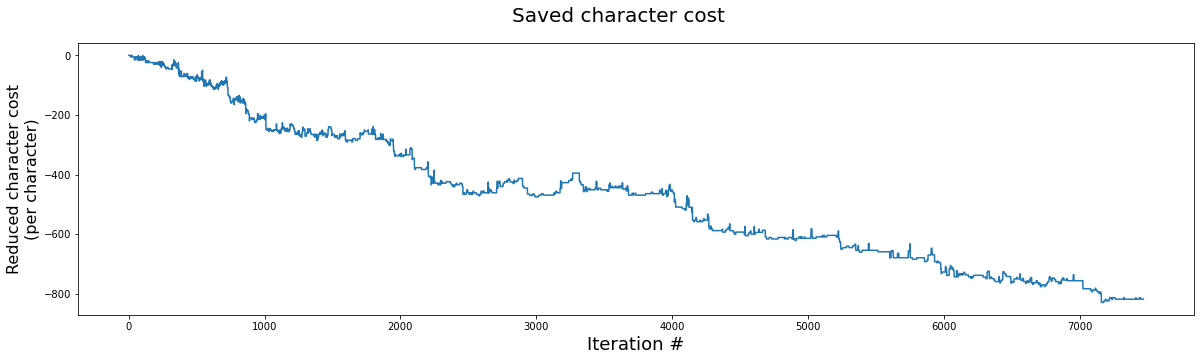

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,5))
plt.plot(tsp.reads)
fig.suptitle('Saved character cost', fontsize=20)
plt.xlabel('Iteration #', fontsize=18)
plt.ylabel('Reduced character cost\n(per character)', fontsize=16)
plt.show()

Found node 596 and 68 with highest -ve costs based on greedy search